In [1]:
import rebound
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pymc3 as pm
import scipy
from scipy.integrate import quad

plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
df = pd.read_csv('../csvs/Kepler-23_stability.csv', index_col=0)
df.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,...,h3,k1,k2,k3,ecom,ejection,t_instability,nbodystable,crossing,spockprob
27048,1999380.0,0.880613,0.201449,0.102941,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,...,0.013028,-0.172274,0.117442,0.006489,0.101288,False,5.358731e+04,False,True,0.010296
27049,1999466.0,1.214257,0.028842,0.021864,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,...,-0.022128,-0.000577,-0.010441,0.004925,0.008076,False,1.000000e+09,True,False,0.787886
27050,1999693.0,1.225737,0.075410,0.066761,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,...,-0.001799,-0.037102,-0.107794,-0.175506,0.104393,False,6.319852e+04,False,False,0.009134
27051,1999943.0,1.083352,0.130139,0.077109,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,...,0.055326,0.024470,-0.146544,-0.128751,0.156694,False,2.133985e+04,False,False,0.005355
27052,1999969.0,1.159434,0.046016,0.051997,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,...,0.047178,-0.075962,-0.010202,0.018394,0.026185,False,6.663452e+04,False,False,0.014513


In [3]:
def calcHPDI(vals, interval, guess, weights=None):
    '''
    Fit a gaussian KDE, find max likelihood, and calculate 
    minimum interval that holds `interval` percentage of the distribution.
    This is what Hadden 2017 quote

        vals : array of values
        interval: float for size of interval
        guess: initial guess for max likelihood
    '''
    vals = np.concatenate([vals, vals*(-1)]) # reflect values to negative to avoid edge effects at zero
    try:
        weights=np.concatenate([weights, weights])
    except:
        pass
    
    kde = scipy.stats.gaussian_kde(vals, bw_method=1/15, weights=weights)
    maxlike = scipy.optimize.fmin(lambda x: -kde(x), x0=guess, disp=False)[0]
    
    sample = kde.resample(10000, seed=0) # need to do this step in case we need to weight the vals by weights (for SPOCK probs)
    samplecut = sample[sample > 0]

    low, high = pm.stats.hpd(samplecut, credible_interval=interval)
    return kde, maxlike, high, low

In [4]:
def plot(ax, df, col, xlabel, lim=1, labels=False):
    Nbins=20
    
    sample1e4 = df[(df['spockprob']>0)&(df['crossing']==False)]
    label = "$10^4$ N-body Orbits\n" if labels else ""
    vals, edges = np.histogram(sample1e4[col], density=True, bins=np.linspace(0,lim,Nbins))
    
    kde, maxlike, high, low = calcHPDI(sample1e4[col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    ax.bar(edges[:-1], vals, width=np.diff(edges), fc='gray', alpha=0.5, label=label, ec='', align='edge')

    nbody = df[(df['nbodystable']==1)]
    label = "$10^9$ N-body Orbits\n" if labels else ""
    vals, edges = np.histogram(nbody[col], density=True, bins=edges)
    
    kde, maxlike, high, low = calcHPDI(nbody[col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    ax.bar(edges[:-1], vals, width=np.diff(edges), alpha=0.5, label=label, ec='', align='edge')


    spock = df[df['crossing']==False]
    label = "SPOCK\n" if labels else ""
    vals, edges = np.histogram(spock[col], density=True, bins=edges, weights=spock.spockprob)
    
    kde, maxlike, high, low = calcHPDI(spock[col], interval=0.683, guess=0.1, weights=spock.spockprob)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    
    ax.bar(edges[:-1], vals, width=np.diff(edges), alpha=0.5, label=label, ec='', align='edge')

    ax.set_xlabel(xlabel)
    ax.set_xlim([0,lim])

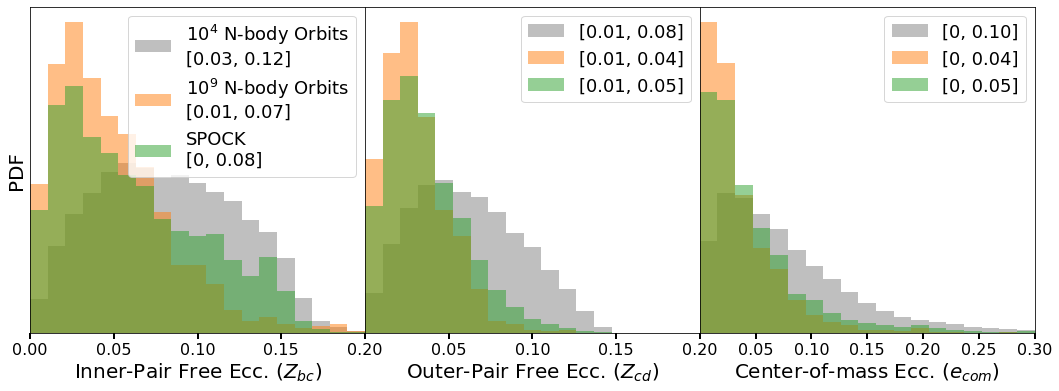

In [5]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)

plot(axarr[0], df, 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', labels=True, lim=0.2)
plot(axarr[1], df, 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', lim=0.2)
plot(axarr[2], df, 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', lim=0.3)

for ax in axarr.flatten():
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[1].set_xticks([0.05,0.1,0.15,0.2])
axarr[2].set_xticks([0.05,0.1,0.15,0.2, 0.25, 0.3])
axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')

In [4]:
def plothist(ax, df, col, label, bins=50):
    ax.hist(df[col][:10000], color='gray', alpha=0.5, density=True, label="Prior", bins=Nbins)
        else:
            ax.hist(df[col][:10000], color='gray', alpha=0.5, density=True, bins=Nbins)

    if df[df['nbodystable']>0].shape[0] > 0:
        label = "N-body\n" if labels else ""
        vals, edges = np.histogram(df[df['nbodystable']==1][col], density=True, bins=np.linspace(0,1,Nbins))

        kde, maxlike, high, low = calcHPDI(df[df['nbodystable']==1][col], interval=0.683, guess=0.1)
        if np.abs(low) >= 0.005:
            label += "[{0:.2f}, {1:.2f}]".format(low, high)
        else:
            label += "[0, {0:.2f}]".format(high)
        ax.bar(edges[:-1], vals, width=np.diff(edges), alpha=0.5, label=label, ec='', align='edge')

    label = "SPOCK\n" if labels else ""
    try:
        if weights:
            vals, edges = np.histogram(df[col], density=True, bins=edges, weights=df.spockprob)
        else:
            vals, edges = np.histogram(df[col], density=True, bins=edges)
    except:
        if weights:
            vals, edges = np.histogram(df[col], density=True, bins=np.linspace(0,1,Nbins), weights=df.spockprob)
        else:
            vals, edges = np.histogram(df[col], density=True, bins=np.linspace(0,1,Nbins))
                                       
    if weights:
        kde, maxlike, high, low = calcHPDI(df[col], interval=0.683, guess=0.1, weights=df.spockprob)
    else:
        kde, maxlike, high, low = calcHPDI(df[col], interval=0.683, guess=0.1)                               
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    
    ax.bar(edges[:-1], vals, width=np.diff(edges), alpha=0.5, label=label, ec='', align='edge')

    ax.set_xlabel(xlabel)

# How much does taking spockprobs skew the distribution of stable systems?

TypeError: plot() got an unexpected keyword argument 'plotprior'

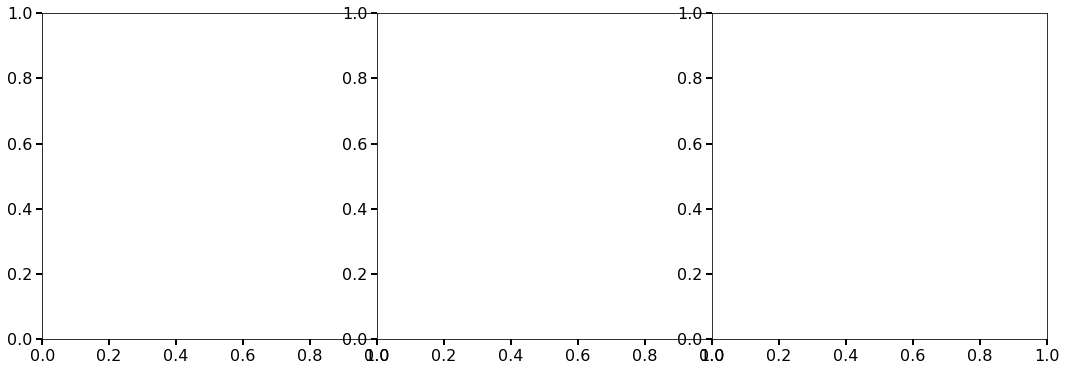

In [18]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)
plot(axarr[0], df[(df['nbodystable']>0) & (df['crossing']==False)], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', labels=True, plotprior=False)
plot(axarr[1], df[(df['nbodystable']>0) & (df['crossing']==False)], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', plotprior=False)
plot(axarr[2], df[(df['nbodystable']>0) & (df['crossing']==False)], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', plotprior=False)

for ax in axarr.flatten():
    ax.set_xlim([0,0.4])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')

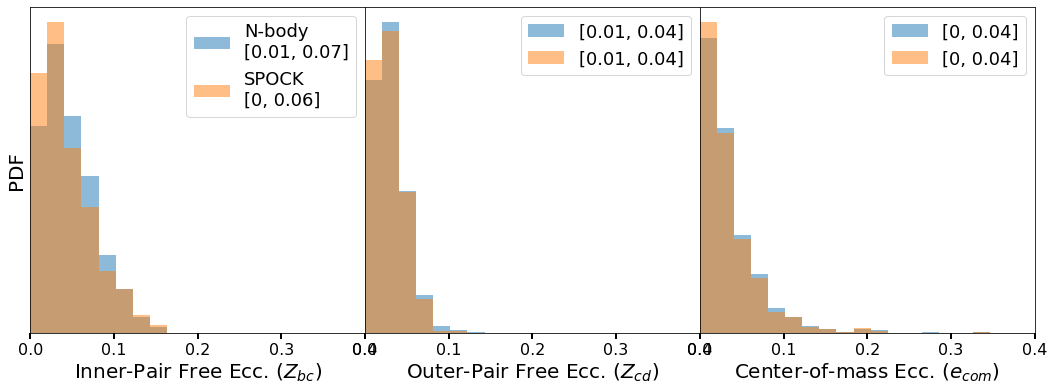

In [34]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)
plot(axarr[0], df[(df['nbodystable']>0) & (df['crossing_Z']==False)], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', labels=True, plotprior=False)
plot(axarr[1], df[(df['nbodystable']>0) & (df['crossing_Z']==False)], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', plotprior=False)
plot(axarr[2], df[(df['nbodystable']>0) & (df['crossing_Z']==False)], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', plotprior=False)

for ax in axarr.flatten():
    ax.set_xlim([0,0.4])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')

# Distribution for unstable systems

Wider...so in cases where there are 20:1 more unstable systems than stable, expect outcome to be skewed

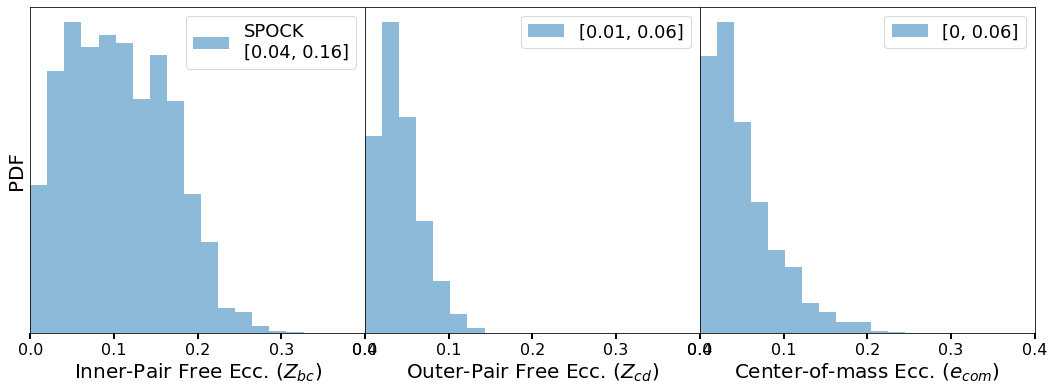

In [53]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)
plot(axarr[0], df[(df['nbodystable']==0) & (df['crossing']==False)], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', labels=True, plotprior=False)
plot(axarr[1], df[(df['nbodystable']==0) & (df['crossing']==False)], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', plotprior=False)
plot(axarr[2], df[(df['nbodystable']==0) & (df['crossing']==False)], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', plotprior=False)

for ax in axarr.flatten():
    ax.set_xlim([0,0.4])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')

In [83]:
edges = np.logspace(-2.5, 0, Nbins+1)
logdelta = np.log10(edges[1])-np.log10(edges[0])
np.log10(edges)

array([-2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125,  0.   ])

In [92]:
logdelta = np.log10(edges[1])-np.log10(edges[0])
logbincenters = np.log10(edges)+logdelta/2
bincenters = 10**logbincenters[:-1]

In [93]:
np.log10(bincenters)

array([-2.4375, -2.3125, -2.1875, -2.0625, -1.9375, -1.8125, -1.6875,
       -1.5625, -1.4375, -1.3125, -1.1875, -1.0625, -0.9375, -0.8125,
       -0.6875, -0.5625, -0.4375, -0.3125, -0.1875, -0.0625])

Text(0, 0.5, 'Fraction actually stable')

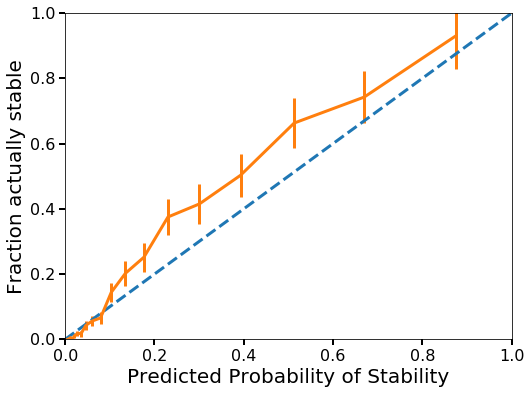

In [7]:
dfc = df.iloc[10000:]
preds = dfc[dfc['crossing'] == False]['spockprob']
testy = dfc[dfc['crossing'] == False]['nbodystable']==1

Nbins = 20
edges = np.logspace(np.log10(preds[preds > 0].min()), 0, Nbins+1)
hist, edges = np.histogram(preds, bins=edges)

logdelta = np.log10(edges[1])-np.log10(edges[0])
logbincenters = np.log10(edges)+logdelta/2
bincenters = 10**logbincenters[:-1]

fracstable = []
errorbars = []
for i in range(len(edges)-1):
    mask = (preds >= edges[i]) & (preds < edges[i+1])
    nstable = testy[mask].sum()
    fracstable.append(nstable/hist[i]) # fraction of stable systems in bin with predictions in range
    errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0, 0.5, 'Fraction actually stable')

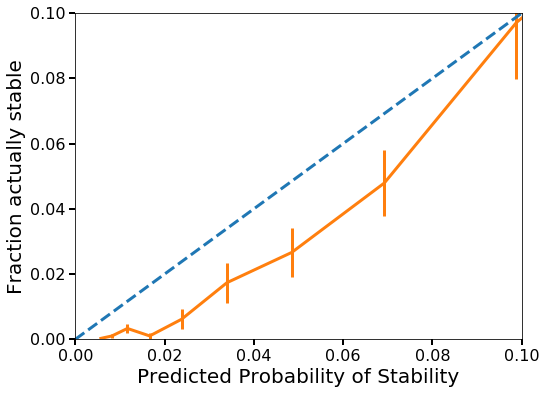

In [8]:
dfc = df.iloc[10000:]
preds = dfc['spockprob']
testy = dfc['nbodystable']==1

Nbins = 15
edges = np.logspace(np.log10(preds[preds > 0].min()), 0, Nbins+1)
hist, edges = np.histogram(preds, bins=edges)

logdelta = np.log10(edges[1])-np.log10(edges[0])
logbincenters = np.log10(edges)+logdelta/2
bincenters = 10**logbincenters[:-1]

fracstable = []
errorbars = []
for i in range(len(edges)-1):
    mask = (preds >= edges[i]) & (preds < edges[i+1])
    nstable = testy[mask].sum()
    fracstable.append(nstable/hist[i]) # fraction of stable systems in bin with predictions in range
    errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,0.1])
ax.set_ylim([0,0.1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

In [33]:
corr = fracstable/bincenters
def reweight(row):
    sp = row['spockprob']
    if sp == 0 or sp > 0.1: # dont' reweight 0 prob or prob > 0.1
        row['rw_spockprob'] = sp
    else:
        for i in range(len(edges)-1):
            if sp >= edges[i] and sp < edges[i+1]:
                row['rw_spockprob'] = sp*corr[i]
    return row

In [33]:
%%time
df = df.apply(reweight, axis=1)

CPU times: user 3.49 s, sys: 52.5 ms, total: 3.55 s
Wall time: 3.55 s


In [64]:
hist

array([2045, 2022, 1225,  698,  511,  373,  287,  316,  370,  267])

In [37]:
1/corr*bincenters/0.1

array([0.63610283, 0.38495159, 0.32116967, 0.44802764, 0.90338683,
       0.60540207, 0.4887549 , 0.62880194, 0.70813183, 0.93828735])

In [70]:
hist*bincenters/(hist*bincenters).sum()

array([0.08198434, 0.10984363, 0.09017495, 0.06962438, 0.06906896,
       0.06831671, 0.07122888, 0.10627165, 0.16861188, 0.16487462])

In [59]:
cut = dfc[dfc['crossing'] == False]
cut = cut[cut['spockprob']<0.1]
cut.rw_spockprob.sum()

77.24436073071122

Text(0, 0.5, 'Fraction actually stable')

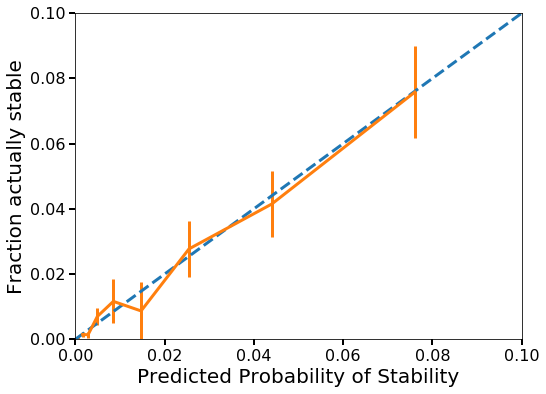

In [35]:
dfc = df.iloc[10000:]
preds = dfc[dfc['crossing'] == False]['rw_spockprob']
testy = dfc[dfc['crossing'] == False]['nbodystable']==1


Nbins = 10
edges = np.logspace(np.log10(preds[preds > 0].min()), -1, Nbins+1)
hist, edges = np.histogram(preds, bins=edges)

logdelta = np.log10(edges[1])-np.log10(edges[0])
logbincenters = np.log10(edges)+logdelta/2
bincenters = 10**logbincenters[:-1]

fracstable = []
errorbars = []
for i in range(len(edges)-1):
    mask = (preds >= edges[i]) & (preds < edges[i+1])
    nstable = testy[mask].sum()
    fracstable.append(nstable/hist[i]) # fraction of stable systems in bin with predictions in range
    errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # 

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,0.1])
ax.set_ylim([0,0.1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

In [36]:
def plotrw(ax, df, col, xlabel, labels=False, plotprior=True, weights=True):
    Nbins=50
    if plotprior:
        if labels:
            ax.hist(df[col][:10000], color='gray', alpha=0.5, density=True, label="Prior", bins=Nbins)
        else:
            ax.hist(df[col][:10000], color='gray', alpha=0.5, density=True, bins=Nbins)

    if df[df['nbodystable']>0].shape[0] > 0:
        label = "N-body\n" if labels else ""
        vals, edges = np.histogram(df[df['nbodystable']==1][col], density=True, bins=np.linspace(0,1,Nbins))

        kde, maxlike, high, low = calcHPDI(df[df['nbodystable']==1][col], interval=0.683, guess=0.1)
        if np.abs(low) >= 0.005:
            label += "[{0:.2f}, {1:.2f}]".format(low, high)
        else:
            label += "[0, {0:.2f}]".format(high)
        ax.bar(edges[:-1], vals, width=np.diff(edges), alpha=0.5, label=label, ec='', align='edge')

    label = "SPOCK\n" if labels else ""
    try:
        if weights:
            vals, edges = np.histogram(df[col], density=True, bins=edges, weights=df.rw_spockprob)
        else:
            vals, edges = np.histogram(df[col], density=True, bins=edges)
    except:
        if weights:
            vals, edges = np.histogram(df[col], density=True, bins=np.linspace(0,1,Nbins), weights=df.rw_spockprob)
        else:
            vals, edges = np.histogram(df[col], density=True, bins=np.linspace(0,1,Nbins))
                                       
    if weights:
        kde, maxlike, high, low = calcHPDI(df[col], interval=0.683, guess=0.1, weights=df.rw_spockprob)
    else:
        kde, maxlike, high, low = calcHPDI(df[col], interval=0.683, guess=0.1)                               
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    
    ax.bar(edges[:-1], vals, width=np.diff(edges), alpha=0.5, label=label, ec='', align='edge')

    ax.set_xlabel(xlabel)

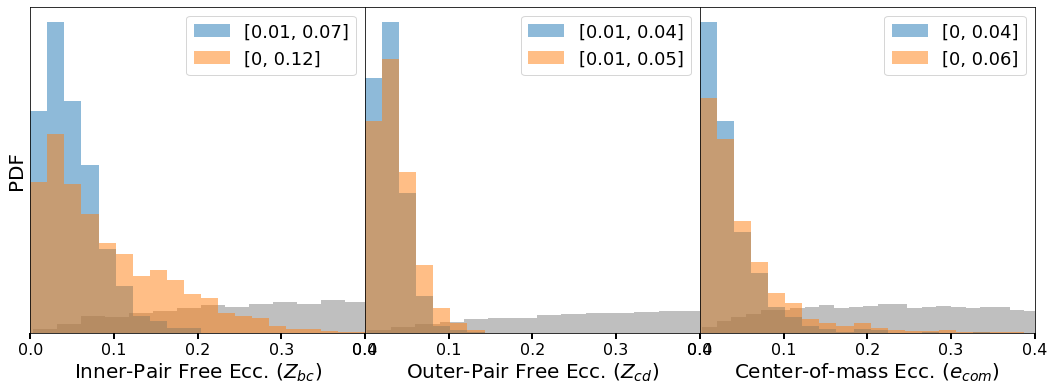

In [143]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)

plot(axarr[0], df, 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)')
plot(axarr[1], df, 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)')
plot(axarr[2], df, 'ecom', 'Center-of-mass Ecc. ($e_{com}$)')

for ax in axarr.flatten():
    ax.set_xlim([0,0.4])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')

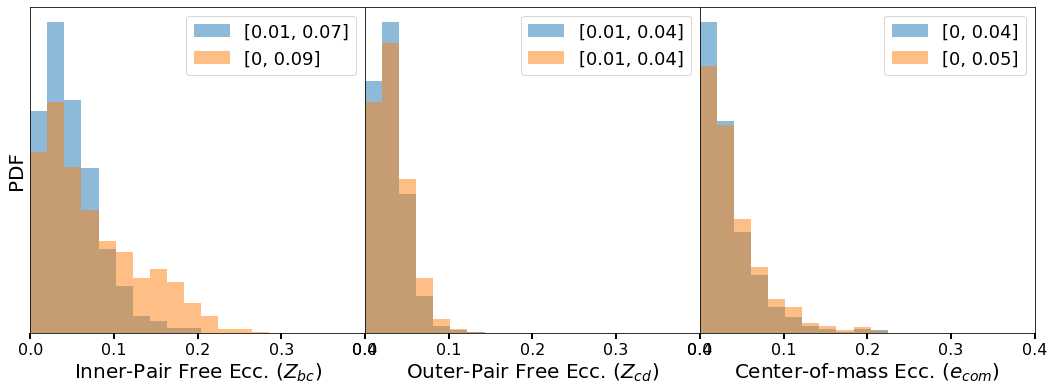

In [37]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)

plotrw(axarr[0], dfc[dfc['crossing'] == False], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', plotprior=False)
plotrw(axarr[1], dfc[dfc['crossing'] == False], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', plotprior=False)
plotrw(axarr[2], dfc[dfc['crossing'] == False], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', plotprior=False)

for ax in axarr.flatten():
    ax.set_xlim([0,0.4])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')

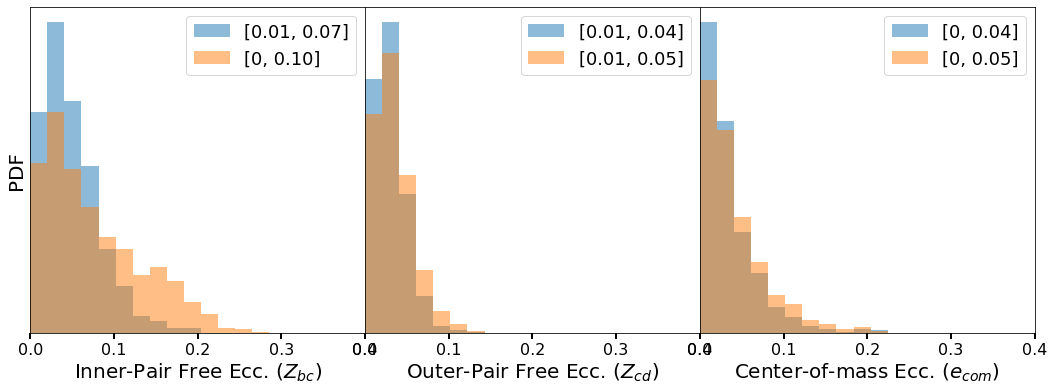

In [13]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)

plot(axarr[0], df[df['crossing']==False], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', plotprior=False)
plot(axarr[1], df[df['crossing']==False], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', plotprior=False)
plot(axarr[2], df[df['crossing']==False], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', plotprior=False)

for ax in axarr.flatten():
    ax.set_xlim([0,0.4])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')

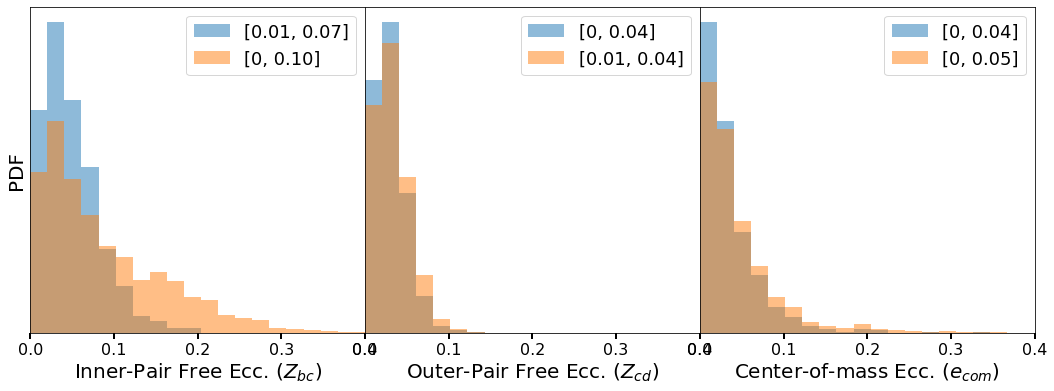

In [11]:
fig, axarr = plt.subplots(ncols=3, figsize=(18,6))
plt.subplots_adjust(wspace=0)

plotrw(axarr[0], df[10000:], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', plotprior=False)
plotrw(axarr[1], df[10000:], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', plotprior=False)
plotrw(axarr[2], df[10000:], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', plotprior=False)

for ax in axarr.flatten():
    ax.set_xlim([0,0.4])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0].set_ylabel('PDF')
fig.savefig('spockcomparison.pdf', bbox_inches='tight')

In [141]:
hist

array([3523,    0, 3937,    0,    0, 2029,  131,  444,  506,  480,  292,
        369,  457,  526,  458])

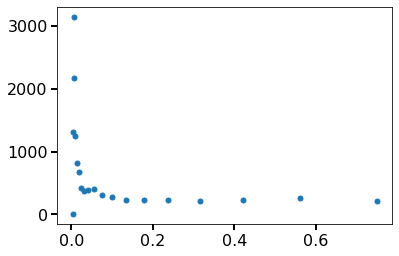

In [58]:
fig, ax = plt.subplots()
ax.plot(edges[:-1], hist, '.')

In [60]:
preds.min()

0.0

Text(0, 0.5, 'Fraction actually stable')

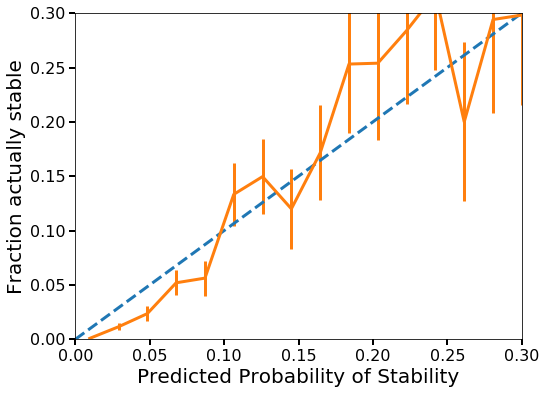

In [70]:
preds = df[10000:]['spockprob']
testy = df[10000:]['nbodystable']==1

hist, edges = np.histogram(preds, bins=50)

bincenters = []
fracstable = []
errorbars = []
for i in range(len(edges)-1):
    bincenters.append((edges[i]+edges[i+1])/2)
    mask = (preds >= edges[i]) & (preds < edges[i+1])
    nstable = testy[mask].sum()
    fracstable.append(nstable/hist[i]) # fraction of stable systems in bin with predictions in range
    errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # 
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,0.3])
ax.set_ylim([0,0.3])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0, 0.5, 'Fraction actually stable')

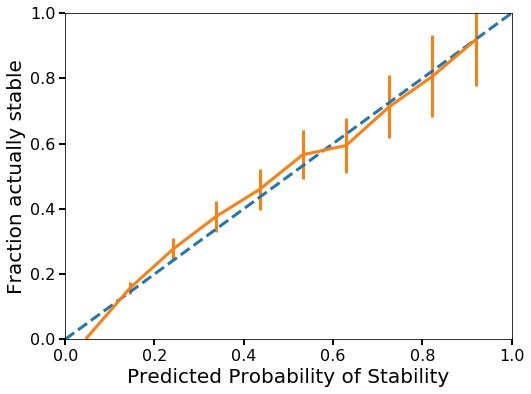

In [66]:
preds = df[10000:]['spockprob']
testy = df[10000:]['nbodystable']==1

hist, edges = np.histogram(preds, bins=10)

bincenters = []
fracstable = []
errorbars = []
for i in range(len(edges)-1):
    bincenters.append((edges[i]+edges[i+1])/2)
    mask = (preds >= edges[i]) & (preds < edges[i+1])
    nstable = testy[mask].sum()
    fracstable.append(nstable/hist[i]) # fraction of stable systems in bin with predictions in range
    errorbars.append(np.sqrt(1./nstable + 1./hist[i])*fracstable[-1]) # 
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

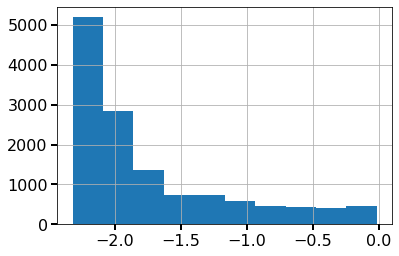

In [41]:
np.log10(df[df['spockprob']>0]['spockprob']).hist()

# Contributions of stable and unstable systems

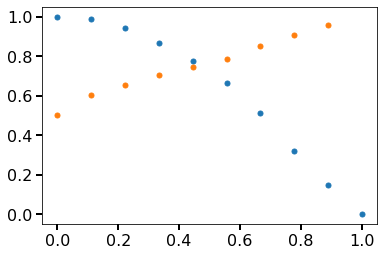

In [84]:
dfc = df[df['crossing'] == False]
stable = dfc[dfc['nbodystable']==1]
unstable = dfc[dfc['nbodystable']==0]

Nout = 10
threshs = np.linspace(0,1,Nout)
frac_stable = np.zeros(Nout)
stable_contrib = np.zeros(Nout)

eff_stable0 = stable[stable['spockprob']>0]['spockprob'].sum()
for i, thresh in enumerate(threshs):
    eff_stable = stable[stable['spockprob']>thresh]['spockprob'].sum()
    eff_unstable = unstable[unstable['spockprob']>thresh]['spockprob'].sum()
    stable_contrib[i] = eff_stable/(eff_stable + eff_unstable)
    frac_stable[i] = eff_stable/eff_stable0
    
fig, ax = plt.subplots()
ax.plot(threshs, frac_stable, '.')
ax.plot(threshs, stable_contrib, '.')

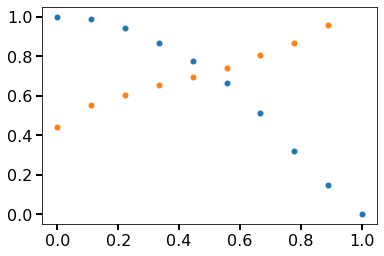

In [47]:
dfc = df[df['crossing'] == False]
stable = dfc[dfc['nbodystable']==1]
unstable = dfc[dfc['nbodystable']==0]

Nout = 10
threshs = np.linspace(0,1,Nout)
frac_stable = np.zeros(Nout)
stable_contrib = np.zeros(Nout)

eff_stable0 = stable[stable['spockprob']>0]['spockprob'].sum()
for i, thresh in enumerate(threshs):
    eff_stable = stable[stable['spockprob']>thresh]['spockprob'].sum()
    eff_unstable = unstable[unstable['spockprob']>thresh]['spockprob'].sum()
    stable_contrib[i] = eff_stable/(eff_stable + eff_unstable)
    frac_stable[i] = eff_stable/eff_stable0
    
fig, ax = plt.subplots()
ax.plot(threshs, frac_stable, '.')
ax.plot(threshs, stable_contrib, '.')

In [44]:
threshs

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [29]:
dfc = df[df['crossing_Z']==False]

In [30]:
dfc[dfc['nbodystable']==1]['spockprob'].sum()

398.4103552480228

In [31]:
dfc[dfc['nbodystable']==1].shape[0]

833

In [32]:
dfc[dfc['nbodystable']==0]['spockprob'].sum()

317.53381597436965

In [33]:
dfc[dfc['nbodystable']==0].shape[0]

9416

In [28]:
dfc[dfc['nbodystable']==1]['rw_spockprob'].sum()

513.6015789275989

In [42]:
dfc[dfc['nbodystable']==0]['rw_spockprob'].sum()

340.47257699198906

In [49]:
vals, edges = np.histogram(dfc[(dfc['nbodystable']==0) & (dfc['spockprob'] > 0)]['spockprob'], bins=20)

In [50]:
vals

array([7432,  635,  248,  157,  108,   79,   69,   50,   38,   37,   28,
         30,   26,   25,   11,   18,    7,    7,    5,    2])

In [51]:
edges

array([0.00479114, 0.05140232, 0.0980135 , 0.14462468, 0.19123586,
       0.23784705, 0.28445823, 0.33106941, 0.37768059, 0.42429177,
       0.47090295, 0.51751413, 0.56412531, 0.61073649, 0.65734767,
       0.70395885, 0.75057004, 0.79718122, 0.8437924 , 0.89040358,
       0.93701476])

In [52]:
delta = edges[1]-edges[0]
bincenters = (edges + delta/2)[:-1]
bincenters

array([0.02809673, 0.07470791, 0.12131909, 0.16793027, 0.21454145,
       0.26115264, 0.30776382, 0.354375  , 0.40098618, 0.44759736,
       0.49420854, 0.54081972, 0.5874309 , 0.63404208, 0.68065326,
       0.72726444, 0.77387563, 0.82048681, 0.86709799, 0.91370917])

In [53]:
vals*bincenters

array([208.81490822,  47.43952434,  30.08713512,  26.36505303,
        23.17047714,  20.63105823,  21.23570335,  17.71874988,
        15.23747478,  16.5611023 ,  13.83783913,  16.22459163,
        15.27320345,  15.85105207,   7.4871859 ,  13.09076   ,
         5.41712938,   5.74340764,   4.33548994,   1.82741834])

In [54]:
df.tail()

,sim,Mstar,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,h1,...,mu1+mu2,mu2+mu3,mutot,ecom,t_instability,nbodystable,spockprob,high_d,rw_spockprob,crossing
27048,1999380.0,0.880613,0.201449,0.139535,0.102941,0.132488,0.198727,0.155031,0.014555,-0.099066,...,0.000015,0.000015,0.000018,0.101288,5.358731e+04,0.0,0.010296,0.0,0.003283,False
27049,1999466.0,1.214257,0.028842,0.012843,0.021864,0.008439,0.039781,0.010983,0.022669,-0.039776,...,0.000043,0.000049,0.000050,0.008076,1.000000e+09,1.0,0.787886,0.0,0.787886,False
27050,1999693.0,1.225737,0.075410,0.120734,0.066761,0.111895,0.088874,0.108052,0.175515,0.080759,...,0.000087,0.000081,0.000091,0.104393,6.319852e+04,0.0,0.009134,0.0,0.002912,False
27051,1999943.0,1.083352,0.130139,0.262373,0.077109,0.180838,0.224166,0.236365,0.140135,0.222827,...,0.000007,0.000024,0.000025,0.156694,2.133985e+04,0.0,0.005355,0.0,0.000470,False
27052,1999969.0,1.159434,0.046016,0.032291,0.051997,0.031372,0.095140,0.020418,0.050637,-0.057283,...,0.000040,0.000122,0.000125,0.026185,5.152893e+05,0.0,0.014513,0.0,0.004495,False


In [55]:
corr

array([0.08767781, 0.19632111, 0.31885607, 0.30972803, 0.20814581,
       0.42087549, 0.70641922, 0.74403928, 0.89526525, 0.91555847])

(0, 210)

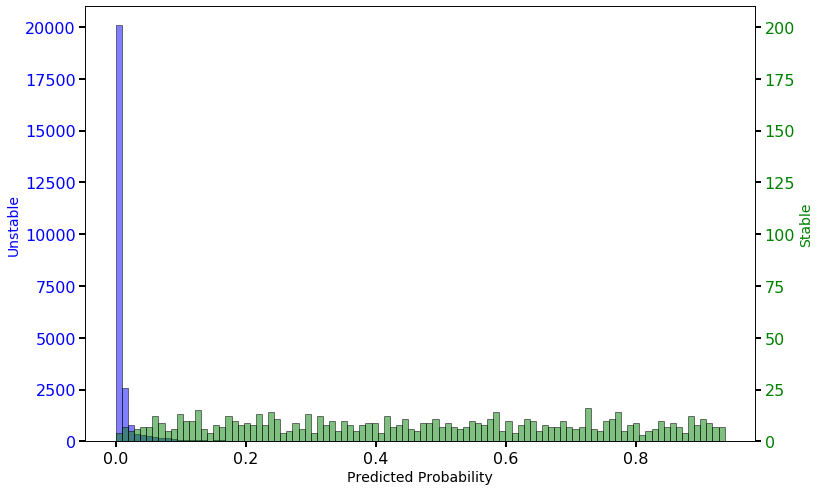

In [9]:
bins = 100
Stable = df[df['nbodystable']==1].spockprob
Unstable = df[df['nbodystable']==0].spockprob

fig, ax1 = plt.subplots(figsize=(12,8))
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=a14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,21000]) # goes up to ~4300
ax2.set_ylim([0,210]) # goes up to ~2100

402.2183520500548


(0, 40)

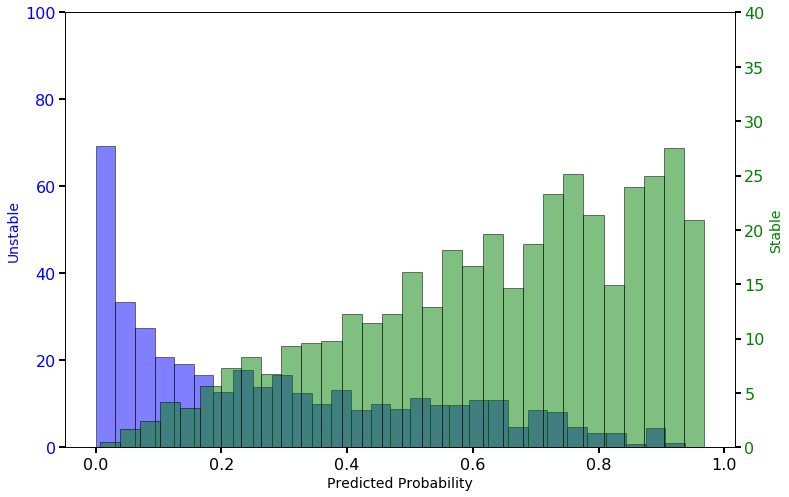

In [83]:
bins = 30
dfc = df[df['crossing']==False]
Stable = dfc[dfc['nbodystable']==1].spockprob
Unstable = dfc[dfc['nbodystable']==0].spockprob

fig, ax1 = plt.subplots(figsize=(12,8))
vals, edges = np.histogram(Unstable, bins=bins, weights=Unstable)
ax1.bar(edges[:-1], vals, width=np.diff(edges), alpha=0.5, label='No', color='blue', edgecolor = "black", align='edge')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
print(vals.sum())
ax2 = ax1.twinx()
vals, edges = np.histogram(Stable, bins=bins, weights=Stable)
ax2.bar(edges[:-1], vals, width=np.diff(edges), alpha=0.5, label='Yes',color='green', edgecolor = "black", align='edge')
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,100]) # goes up to ~4300
ax2.set_ylim([0,40]) # goes up to ~2100

(0, 210)

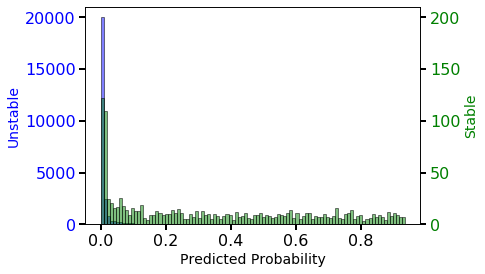

In [211]:
bins = 100
Stable = df[df['nbodystable']==1].spockprob
Unstable = df[df['nbodystable']==0].spockprob

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
       
ax1.set_ylim([0,21000]) # goes up to ~4300
ax2.set_ylim([0,210]) # goes up to ~2100

In [4]:
resthresh, restpr, resfpr = np.loadtxt('../spock/spock/models/resROC.txt')
randthresh, randtpr, randfpr = np.loadtxt('../spock/spock/models/randROC.txt')

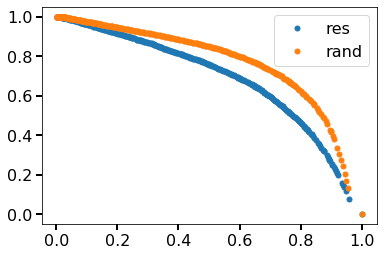

In [5]:
fig, ax = plt.subplots()
ax.plot(resthresh, restpr, '.', label='res')
ax.plot(randthresh, randtpr, '.', label='rand')
ax.legend()

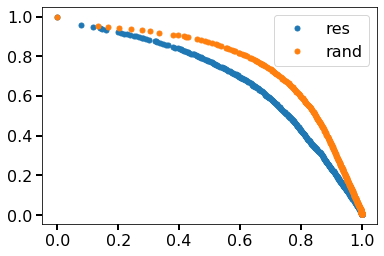

In [6]:
fig, ax = plt.subplots()
ax.plot(restpr, resthresh, '.', label='res')
ax.plot(randtpr, randthresh, '.', label='rand')
ax.legend()